# Imports

In [1]:
import numpy as np
import gym
import random
import copy
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot as plt

# Actor critic methods

In [2]:
class Actor(nn.Module):
    def __init__(self, scaling, state_size, hidden_size, action_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x)) * scaling

In [3]:
class Critic(nn.Module):
    def __init__(self, state_size, hidden_size, action_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size + action_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
    
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

## TD3

### Defining the agent

In [4]:
class TD3_Agent():
    def __init__(self, scaling, render, buffer_size, batch_size, gamma, tau, sigma,
                state_size, hidden_size, action_size, actor_lr, critic_lr):
        
        self.scaling = scaling
        self.render = render
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.sigma = sigma

        self.state_size = state_size
        self.hidden_size = hidden_size
        self.action_size = action_size
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        
        # Create actor network, 2 critic networks, their target copies, and their optimisers
        self.actor = Actor(scaling, state_size, hidden_size, action_size)
        self.critic = Critic(state_size, hidden_size, action_size)
        self.critic2 = Critic(state_size, hidden_size, action_size)
        self.target_actor = copy.deepcopy(self.actor)
        self.target_critic = copy.deepcopy(self.critic)
        self.target_critic2 = copy.deepcopy(self.critic2)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr = actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr = critic_lr)
        self.critic_optimizer2 = torch.optim.Adam(self.critic2.parameters(), lr = critic_lr)
        
        self.state_memory = []
        self.next_state_memory = []
        self.action_memory = []
        self.reward_memory = []
        self.terminal_memory = []
        self.memory_counter = 0
        
    def train(self):
        state = env.reset()
        ep_reward = 0
        num_step = 0
        terminal = False
        
        while not terminal:
            
            if self.render:
                env.render()
                
            tensor_state = torch.from_numpy(state).float()            
            action = self.actor(tensor_state)
            action = torch.add(action, torch.from_numpy(np.random.normal(0, self.sigma, self.action_size)))
            action = action.detach().numpy()
            next_state, reward, terminal, _ = env.step(action)
            ep_reward += reward

            if self.memory_counter < self.buffer_size: 
                self.state_memory.append(state)
                self.next_state_memory.append(next_state)
                self.action_memory.append(action)
                self.reward_memory.append(reward)
                self.terminal_memory.append(1 - terminal)
            else:     
                index = self.memory_counter % self.buffer_size
                self.state_memory[index] = state
                self.next_state_memory[index] = next_state
                self.action_memory[index] = action
                self.reward_memory[index] = reward
                self.terminal_memory[index] = 1 - terminal
            self.memory_counter += 1    
            
            if self.memory_counter >= self.batch_size: 
                batch = random.sample(range(len(self.state_memory)), self.batch_size) 
                states = []
                next_states = []
                actions = []
                rewards = []
                terminals = []
                
                for item in batch:
                    states.append(self.state_memory[item])
                    next_states.append(self.next_state_memory[item])
                    actions.append(self.action_memory[item])
                    rewards.append(self.reward_memory[item]) 
                    terminals.append(self.terminal_memory[item])
                
                states = np.array(states)
                next_states = np.array(next_states)
                actions = np.array(actions)
                states = torch.tensor(states)
                next_states = torch.tensor(next_states)
                actions = torch.tensor(actions)
                states = states.to(torch.float32) 
                actions = actions.to(torch.float32) 
                next_states = next_states.to(torch.float32) 
                    
                # Calculate policy noise then clip this noise
                # Add this policy noise to the actions that are selected by the actor network when given the next state
                target_actions = self.target_actor(next_states)
                actions_copy = copy.deepcopy(actions)
                noise = actions_copy.data.normal_(0, self.sigma * 2)
                noise = noise.clamp(-self.sigma * 5, self.sigma * 5)      
                target_actions = target_actions + noise
                
                # Calculate the actual next state Q values for each target critic network
                # Choose the smaller of these two next state Q values
                # Use this to calculate the value of actual current state Q values
                a = self.target_critic(next_states, target_actions)
                b = self.target_critic2(next_states, target_actions)
                next_Qtargets = torch.min(a,b) 
                Qtargets = []
                for i in range(self.batch_size):
                    Qtargets.append(rewards[i] + self.gamma * next_Qtargets[i] * terminals[i])
                Qtargets = torch.tensor(Qtargets)
                Qtargets = Qtargets.view(self.batch_size, 1)
                
                # Perform gradient descent on the first critic network             
                Qexpected = self.critic(states, actions)
                critic_loss = nn.MSELoss()(Qexpected, Qtargets)
                self.critic_optimizer.zero_grad()
                critic_loss.backward()
                self.critic_optimizer.step()
                
                # Perform gradient descent on the second critic network       
                Qexpected2 = self.critic2(states, actions)
                critic_loss2 = nn.MSELoss()(Qexpected2, Qtargets)
                self.critic_optimizer2.zero_grad()
                critic_loss2.backward()
                self.critic_optimizer2.step()
                
                # Perform gradient ascent on the actor network every 2 steps
                if num_step % 2 == 0:
                    actions_predicted = self.actor(states)
                    actor_loss = -self.critic(states, actions_predicted)
                    actor_loss = torch.mean(actor_loss)
                    self.actor_optimizer.zero_grad()
                    actor_loss.backward()
                    self.actor_optimizer.step()
                
                # Update all target networks
                with torch.no_grad():
                    for target_parameter, parameter in zip(self.target_critic.parameters(), self.critic.parameters()):
                        target_parameter.copy_((target_parameter * (1 - self.tau)) + (parameter * self.tau))                    

                with torch.no_grad():
                    for target_parameter, parameter in zip(self.target_critic2.parameters(), self.critic2.parameters()):
                        target_parameter.copy_((target_parameter * (1 - self.tau)) + (parameter * self.tau)) 
                
                with torch.no_grad():
                    for target_parameter, parameter in zip(self.target_actor.parameters(), self.actor.parameters()):
                        target_parameter.copy_((target_parameter * (1 - self.tau)) + (parameter * self.tau))      
                
            state = next_state
            num_step += 1
            
        if self.render:
            env.close()
            
        return ep_reward
    
    def test(self):
        
        scores = []
        
        for i in range(100):
            state = env.reset()
            terminal = False
            ep_reward = 0

            while not terminal:
                tensor_state = torch.from_numpy(state).float()
                action = self.actor(tensor_state)
                action = action.detach().numpy()
                next_state, reward, terminal, _ = env.step(action)
                ep_reward += reward 
                state = next_state
                
            scores.append(ep_reward)
        
        print('Mean score:', np.mean(scores))
        x = [i for i in range(1, len(scores)+1)]
        plt.plot(x, scores)
        plt.ylabel('Score')
        plt.xlabel('Episodes')
        plt.show()

    def visualise(self):
        for i in range(10):
            state = env.reset()
            terminal = False
            ep_reward = 0

            while not terminal:
                env.render()
                tensor_state = torch.from_numpy(state).float()
                action = self.actor(tensor_state)
                action = action.detach().numpy()
                next_state, reward, terminal, _ = env.step(action)
                ep_reward += reward 
                state = next_state

            print('Episode reward:', ep_reward)
            env.close()

### BipedalWalker-v3

*************************************************************
Agent 1
Episode: 100 Score: -110.447 	 Mean score over last 100 episodes: -107.410
Episode: 200 Score: -89.333 	 Mean score over last 100 episodes: -94.266
Episode: 300 Score: -91.820 	 Mean score over last 100 episodes: -106.959
Episode: 400 Score: -114.438 	 Mean score over last 100 episodes: -85.677
Episode: 500 Score: -68.846 	 Mean score over last 100 episodes: -75.447
Episode: 600 Score: 119.878 	 Mean score over last 100 episodes: 15.889
Episode: 700 Score: 253.343 	 Mean score over last 100 episodes: 192.544
Episode: 800 Score: 262.838 	 Mean score over last 100 episodes: 228.503
Episode: 900 Score: 271.146 	 Mean score over last 100 episodes: 266.990
Episode: 1000 Score: 279.750 	 Mean score over last 100 episodes: 269.734
Episode: 1100 Score: 276.433 	 Mean score over last 100 episodes: 276.367
Episode: 1200 Score: 278.496 	 Mean score over last 100 episodes: 268.108
Episode: 1300 Score: 280.214 	 Mean score over l

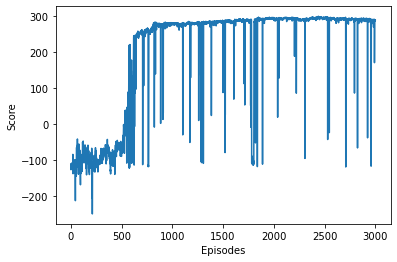

Agent 1 mean score of last 100 episodes during training


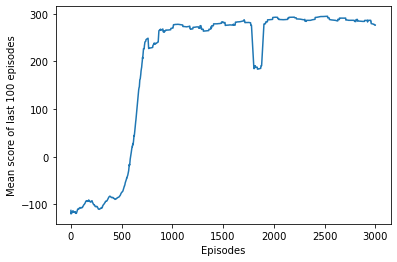

Agent 1 scores during testing
Mean score: 288.388414526982


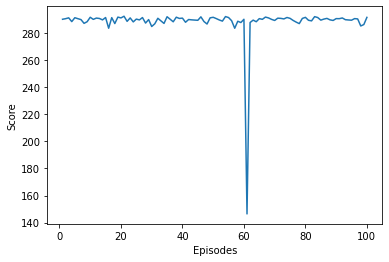

In [5]:
environment = 'BipedalWalker-v3'
env = gym.make(environment)

if environment == 'Pendulum-v1':
    scaling = 2
    solved = -100
elif environment =='BipedalWalker-v3' or 'BipedalWalkerHardcore-v3':
    scaling = 1
    solved = 300 

previous = 100
print_every = 100
agents = 1

for i in range(1, agents + 1): 
    print('*************************************************************')
    print('Agent {}'.format(i))

    walker_TD3 = TD3_Agent(scaling = scaling, render = False, buffer_size = 500000, batch_size = 64, gamma = 0.99, tau = 0.005, sigma = 0.1,
                state_size = env.observation_space.shape[0], hidden_size = 64, action_size = env.action_space.shape[0], actor_lr = 0.0004, critic_lr = 0.0004)
    agent_scores = [0]
    agent_moving_means = [0]
    episode = 1

    while (agent_moving_means[-1] < solved or episode <= previous) and episode < 3001:

        ep_reward = walker_TD3.train()

        if episode == 1: 
            agent_scores[0] = ep_reward
            agent_moving_means[0] = ep_reward
        else:
            agent_scores.append(ep_reward)
            agent_moving_means.append(np.mean(agent_scores[-previous:])) 

        if episode % print_every == 0:
            print('Episode: {} Score: {:.3f} \t Mean score over last {} episodes: {:.3f}'.format(episode, ep_reward, previous, agent_moving_means[-1])) 

        episode += 1

    episode -= 1
    print('*********************************')
    print('Agent {} complete \t Mean score of agent: {:.3f}'.format(i, np.mean(agent_scores))) 
    print('{} finished in {} episodes \t Mean score over last {} episodes: {:.3f}'.format(environment, episode, previous, agent_moving_means[-1]))
    print('*********************************')

    x = [i for i in range(1, len(agent_scores) + 1)]
    print('Agent {} scores during training'.format(i))
    plt.plot(x, agent_scores)
    plt.ylabel('Score')
    plt.xlabel('Episodes')              
    plt.show()

    x = [i for i in range(1, len(agent_moving_means) + 1)]
    print('Agent {} mean score of last {} episodes during training'.format(i, previous))
    plt.plot(x, agent_moving_means)
    plt.ylabel('Mean score of last {} episodes'.format(previous))       
    plt.xlabel('Episodes')
    plt.show()
    
    print('Agent {} scores during testing'.format(i))
    walker_TD3.test()

In [6]:
environment = 'BipedalWalker-v3'
env = gym.make(environment)
walker_TD3.visualise()

2022-05-05 16:48:55.169 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff357320f20>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:48:55.170 python[1109:8020] Warning: Expected min height of view: (<NSButton: 0x7ff372739ca0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:48:55.172 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff366524ea0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:48:55.174 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff372726ae0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 293.18009381252654


2022-05-05 16:49:01.709 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff35c089760>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:49:01.712 python[1109:8020] Warning: Expected min height of view: (<NSButton: 0x7ff35c016ba0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:49:01.718 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff35c00cea0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:49:01.724 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff35c036b20>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 289.5185655902517


2022-05-05 16:49:08.633 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff35313b9c0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:49:08.637 python[1109:8020] Warning: Expected min height of view: (<NSButton: 0x7ff3573cd0e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:49:08.645 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff35733d8e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:49:08.651 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff3531604e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 288.91200917984776


2022-05-05 16:49:14.933 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff35b66b120>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:49:14.933 python[1109:8020] Warning: Expected min height of view: (<NSButton: 0x7ff3727814e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:49:14.937 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff372708c30>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:49:14.944 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff3564e9450>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 289.45285019371664


2022-05-05 16:49:21.590 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff3581ebca0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:49:21.591 python[1109:8020] Warning: Expected min height of view: (<NSButton: 0x7ff3581a2260>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:49:21.593 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff3581a1060>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:49:21.595 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff35819e220>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 289.07290917625164


2022-05-05 16:49:27.973 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff35cb67160>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:49:27.977 python[1109:8020] Warning: Expected min height of view: (<NSButton: 0x7ff3581a56e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:49:27.984 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff358161be0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:49:27.990 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff35813b1a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 287.0350361518123


2022-05-05 16:49:34.536 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff35819e4d0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:49:34.539 python[1109:8020] Warning: Expected min height of view: (<NSButton: 0x7ff358188760>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:49:34.547 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff358181820>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:49:34.552 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff358148220>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 286.4980818300712


2022-05-05 16:49:40.879 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff35815bd60>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:49:40.883 python[1109:8020] Warning: Expected min height of view: (<NSButton: 0x7ff358152860>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:49:40.892 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff3581c5220>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:49:40.898 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff3581c0de0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 288.79157871969534


2022-05-05 16:49:47.863 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff35ad1e8e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:49:47.865 python[1109:8020] Warning: Expected min height of view: (<NSButton: 0x7ff35ad7eca0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:49:47.871 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff35ad7b660>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:49:47.874 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff35addb9e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 290.0827999945851


2022-05-05 16:49:55.220 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff37194eea0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:49:55.221 python[1109:8020] Warning: Expected min height of view: (<NSButton: 0x7ff35c053240>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:49:55.224 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff35c04a020>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:49:55.226 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff35c0482a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: 290.660254714617


### BipedalWalkerHardcore-v3

##### Testing the last trained agent on BipedalWalkerHardcore-v3

Scores during testing
Mean score: -93.24818283115924


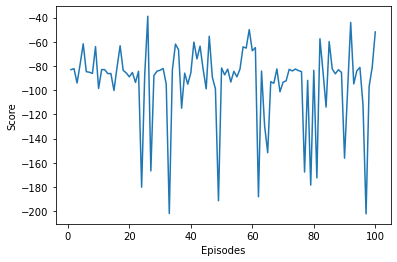

In [7]:
environment = 'BipedalWalkerHardcore-v3'
env = gym.make(environment)

scores = []

for i in range(100):
    state = env.reset()
    terminal = False
    ep_reward = 0

    while not terminal:
        tensor_state = torch.from_numpy(state).float()
        action = walker_TD3.actor(tensor_state)
        action = action.detach().numpy()
        next_state, reward, terminal, _ = env.step(action)
        ep_reward += reward 
        state = next_state

    scores.append(ep_reward)

print('Scores during testing')
print('Mean score:', np.mean(scores))
x = [i for i in range(1, len(scores)+1)]
plt.plot(x, scores)
plt.ylabel('Score')
plt.xlabel('Episodes')
plt.show()

In [8]:
environment = 'BipedalWalkerHardcore-v3'
env = gym.make(environment)
walker_TD3.visualise()

2022-05-05 16:50:47.540 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff358132f60>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:50:47.543 python[1109:8020] Warning: Expected min height of view: (<NSButton: 0x7ff360f06f00>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:50:47.553 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff36bb25c60>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:50:47.559 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff360d09ba0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -77.95429367213791


2022-05-05 16:50:58.587 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff35f9dca90>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:50:58.589 python[1109:8020] Warning: Expected min height of view: (<NSButton: 0x7ff360d0c160>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:50:58.595 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff360d0f5f0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:50:58.600 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff357729ad0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -85.42166184642974


2022-05-05 16:51:00.967 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff360f0a4e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:51:00.968 python[1109:8020] Warning: Expected min height of view: (<NSButton: 0x7ff360f101a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:51:00.974 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff360f10930>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:51:00.978 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff360d16950>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -55.696593533239025


2022-05-05 16:51:05.383 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff360e1f7e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:51:05.384 python[1109:8020] Warning: Expected min height of view: (<NSButton: 0x7ff35f9147e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:51:05.391 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff359deeaa0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:51:05.400 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff360d11c60>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -85.50256008219424


2022-05-05 16:51:07.462 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff359d6e0e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:51:07.463 python[1109:8020] Warning: Expected min height of view: (<NSButton: 0x7ff359d657e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:51:07.468 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff359d66a60>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:51:07.472 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff359dba6a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -61.4331786130168


2022-05-05 16:51:11.412 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff360e1c1c0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:51:11.413 python[1109:8020] Warning: Expected min height of view: (<NSButton: 0x7ff360e26760>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:51:11.418 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff360d21410>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:51:11.422 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff360d22190>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -67.42225657970025


2022-05-05 16:51:14.626 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff35c00daa0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:51:14.627 python[1109:8020] Warning: Expected min height of view: (<NSButton: 0x7ff35b68fd20>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:51:14.631 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff35b686de0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:51:14.634 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff35b683ce0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -70.72093409796305


2022-05-05 16:51:17.744 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff360d1aa80>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:51:17.745 python[1109:8020] Warning: Expected min height of view: (<NSButton: 0x7ff360d2beb0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:51:17.749 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff360d2c640>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:51:17.752 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff360d2d3c0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -87.7380984782707


2022-05-05 16:51:19.728 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff35f9cda40>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:51:19.729 python[1109:8020] Warning: Expected min height of view: (<NSButton: 0x7ff355b0f500>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:51:19.733 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff355b0f7b0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:51:19.736 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff355b09e60>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -173.42195493940287


2022-05-05 16:51:47.134 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff342f0b4f0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:51:47.134 python[1109:8020] Warning: Expected min height of view: (<NSButton: 0x7ff360d2f850>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:51:47.137 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff360d2ffe0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-05 16:51:47.140 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff360f2c3c0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -182.08500477828005


#### Continue training the most recent TD3 BipedalWalker-v3 agent on BipedalWalkerHardcore-v3

*************************************************************
Agent 1
Episode: 100 Score: -25.954 	 Mean score over last 100 episodes: -115.034
Episode: 200 Score: -87.094 	 Mean score over last 100 episodes: -126.511
Episode: 300 Score: -99.587 	 Mean score over last 100 episodes: -140.087
Episode: 400 Score: -152.907 	 Mean score over last 100 episodes: -161.388
Episode: 500 Score: -178.533 	 Mean score over last 100 episodes: -175.320
Episode: 600 Score: -157.546 	 Mean score over last 100 episodes: -162.516
Episode: 700 Score: -201.446 	 Mean score over last 100 episodes: -184.528
Episode: 800 Score: -167.059 	 Mean score over last 100 episodes: -178.601
Episode: 900 Score: -176.357 	 Mean score over last 100 episodes: -182.537
Episode: 1000 Score: -201.526 	 Mean score over last 100 episodes: -179.289
Episode: 1100 Score: -158.669 	 Mean score over last 100 episodes: -163.779
Episode: 1200 Score: -164.865 	 Mean score over last 100 episodes: -166.858
Episode: 1300 Score: -184.371 

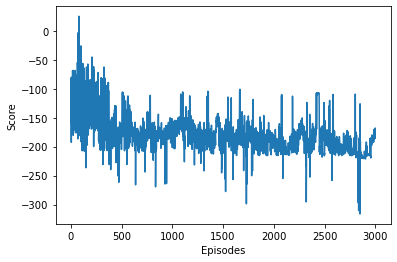

Agent 1 mean score of last 100 episodes during training


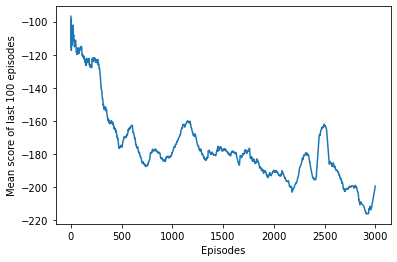

Scores during testing
Mean score: -174.87711348909954


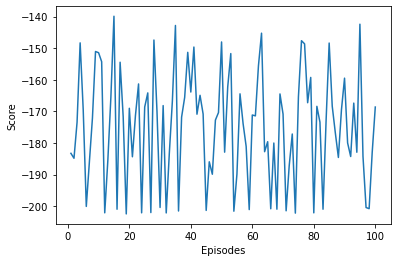

In [9]:
# Create deep copy to not overwrite walker_TD3
hardcore_adapt_TD3 = copy.deepcopy(walker_TD3)

if environment == 'Pendulum-v1':
    scaling = 2
    solved = -100
elif environment =='BipedalWalker-v3' or 'BipedalWalkerHardcore-v3':
    scaling = 1
    solved = 300 

previous = 100
print_every = 100

print('*************************************************************')
print('Agent 1')

agent_scores = [0]
agent_moving_means = [0]
episode = 1

while (agent_moving_means[-1] < solved or episode <= previous) and episode < 3001:

    ep_reward = hardcore_adapt_TD3.train()

    if episode == 1: 
        agent_scores[0] = ep_reward
        agent_moving_means[0] = ep_reward
    else:
        agent_scores.append(ep_reward)
        agent_moving_means.append(np.mean(agent_scores[-previous:])) 

    if episode % print_every == 0:
        print('Episode: {} Score: {:.3f} \t Mean score over last {} episodes: {:.3f}'.format(episode, ep_reward, previous, agent_moving_means[-1])) 

    episode += 1

episode -= 1
print('*********************************')
print('Agent 1 complete \t Mean score of agent: {:.3f}'.format(np.mean(agent_scores))) 
print('{} finished in {} episodes \t Mean score over last {} episodes: {:.3f}'.format(environment, episode, previous, agent_moving_means[-1]))
print('*********************************')

x = [i for i in range(1, len(agent_scores) + 1)]
print('Agent 1 scores during training')
plt.plot(x, agent_scores)
plt.ylabel('Score')
plt.xlabel('Episodes')              
plt.show()

x = [i for i in range(1, len(agent_moving_means) + 1)]
print('Agent 1 mean score of last {} episodes during training'.format(previous))
plt.plot(x, agent_moving_means)
plt.ylabel('Mean score of last {} episodes'.format(previous))       
plt.xlabel('Episodes')
plt.show()

print('Scores during testing')
hardcore_adapt_TD3.test()

In [10]:
environment = 'BipedalWalkerHardcore-v3'
env = gym.make(environment)
hardcore_adapt_TD3.visualise()

2022-05-06 07:13:21.683 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff339c7d360>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-06 07:13:21.684 python[1109:8020] Warning: Expected min height of view: (<NSButton: 0x7ff3390ec760>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-06 07:13:21.687 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff3390d9860>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-06 07:13:21.690 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff339351ea0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -171.27851557538852


2022-05-06 07:13:45.962 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff339f62b20>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-06 07:13:45.963 python[1109:8020] Warning: Expected min height of view: (<NSButton: 0x7ff3393ef860>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-06 07:13:45.967 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff33901c5d0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-06 07:13:45.970 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff3390fd9a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -183.41718249282653


2022-05-06 07:14:07.647 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff360f27ae0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-06 07:14:07.649 python[1109:8020] Warning: Expected min height of view: (<NSButton: 0x7ff3390c01a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-06 07:14:07.651 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff339c816a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-06 07:14:07.654 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff33915a9e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -170.16165324722886


2022-05-06 07:14:27.569 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff360f24d20>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-06 07:14:27.569 python[1109:8020] Warning: Expected min height of view: (<NSButton: 0x7ff3397278e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-06 07:14:27.572 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff363d214e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-06 07:14:27.575 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff339f699c0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -171.3538439348933


2022-05-06 07:14:49.705 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff3397384e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-06 07:14:49.706 python[1109:8020] Warning: Expected min height of view: (<NSButton: 0x7ff339f10ba0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-06 07:14:49.709 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff339f0ccd0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-06 07:14:49.711 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff33a231be0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -201.93234045945272


2022-05-06 07:15:09.979 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff339ab0420>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-06 07:15:09.980 python[1109:8020] Warning: Expected min height of view: (<NSButton: 0x7ff339afebe0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-06 07:15:09.982 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff339a4a7a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-06 07:15:09.984 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff339a45920>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -202.25014071281845


2022-05-06 07:15:27.232 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff339ad3fa0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-06 07:15:27.232 python[1109:8020] Warning: Expected min height of view: (<NSButton: 0x7ff360e28830>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-06 07:15:27.234 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff360e2fc90>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-06 07:15:27.238 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff360e30160>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -200.42952011093266


2022-05-06 07:15:44.482 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff339bd86a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-06 07:15:44.482 python[1109:8020] Warning: Expected min height of view: (<NSButton: 0x7ff33a6cd460>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-06 07:15:44.485 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff33a6fe1e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-06 07:15:44.487 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff360d78620>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -183.14145414035278


2022-05-06 07:16:03.827 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff339c7a560>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-06 07:16:03.831 python[1109:8020] Warning: Expected min height of view: (<NSButton: 0x7ff33a1bf460>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-06 07:16:03.838 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff33a1fbc60>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-06 07:16:03.845 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff3394db5e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -184.232114501269


2022-05-06 07:16:29.994 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff360e1afd0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-06 07:16:29.995 python[1109:8020] Warning: Expected min height of view: (<NSButton: 0x7ff359d179e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-06 07:16:29.997 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff3391a31e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2022-05-06 07:16:30.005 python[1109:8020] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7ff339772e60>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Episode reward: -202.77484273287382
